## Understanding NMR Spectroscopy: Chemical Shift & Intensity  

### Chemical Shift (δ)  
- **Chemical shift** tells us how **shielded or deshielded** a nucleus is by electrons.  
- The closer a nucleus is to an **electronegative atom**, the more **deshielded** it becomes, moving **downfield (higher ppm)**.  
- The further it is from electronegative atoms, the more **shielded**, moving **upfield (lower ppm)**.  
- Chemical shift is calculated using:  

  $$
  \delta = \frac{\nu_{\text{sample}} - \nu_{\text{reference}}}{\nu_{\text{reference}}} \times 10^6
  $$

  where:  
  - $ \nu_{\text{sample}} $ = Resonance frequency of the sample.  
  - $ \nu_{\text{reference}} $ = Resonance frequency of a reference compound (e.g., **TMS for $ ^1H $-NMR**).  

### Intensity in NMR  
- **Intensity** represents the number of **nuclei absorbing RF energy** at a given frequency.  
- A peak's intensity is **proportional to the number of equivalent nuclei** in that environment.  
- In **$ ^1H $-NMR**, the **area under the peaks (integration)** reveals **relative proton counts**.  


Chemical shift tells us where a peak appears on the NMR spectrum. It’s like a “fingerprint” for the environment around each hydrogen atom. Where the peak is = type of hydrogen. How big the peak is = how many hydrogens. 

# Parse and Analyze Data

This is where we get the raw nmr data and get it visualized so that it can be fourier transformed

In [1]:
import pandas as pd
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns



here I just took in the data file and then delimiter is just a format thing and skip header = 1 means to not skip the header or the 0 values of the header 

In [2]:
# Try reading the ASCII FID file manually
data = np.genfromtxt(r"c:\Users\Windows User\Documents\JEOL\data\13_03_11_indst_1H fid.asc", delimiter='\t', skip_header=1)

# Create a DataFrame with appropriate column names
df = pd.DataFrame(data, columns=['X', 'Real', 'Imaginary'])

# Display the first few rows of the DataFrame
print(df.head())

name = "JEOL data 13_03_11_indst_1H"

          X      Real  Imaginary
0  0.000000  0.000003   0.000009
1  0.000133 -0.001235  -0.003140
2  0.000267  0.050601   0.188029
3  0.000400  0.019175   0.365893
4  0.000533 -0.136525  -0.611649


This is a molecular proposition (aka boolean statement) that says to plot the first and second columns from the dataset, which should be the x values and the real number values. Then I just plotted the thing

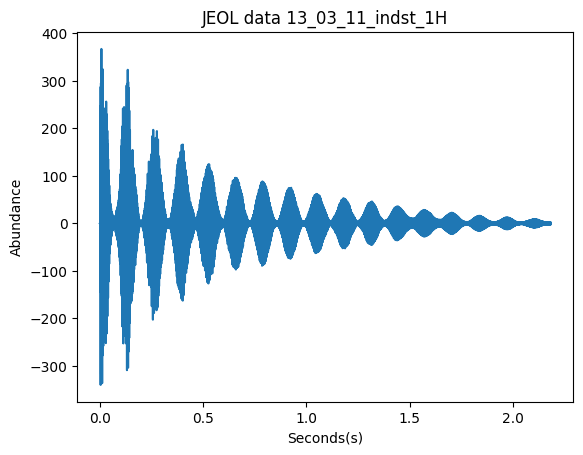

In [3]:
# Ensure data is not None and has valid content
if data is not None and data.size > 0:
	plt.plot(data[:, 0], data[:, 1])  # Assuming the first column is X and the second column is Intensity
	#plt.gca().invert_xaxis()  # Invert x-axis, use after fourier transform
	plt.title(name)
	plt.xlabel("Seconds(s)")
	plt.ylabel("Abundance")
	plt.show()
else:
	print("No valid data found in the file.")


# Fourier Transofrm

Since that the inputted free induction decay (FID) data is a sampled dignal we use the Discrete Fourier Transform. This means using the fft function to get a finite set of frquency components. It is over a finite amount of time (N over a time T, where $N\Delta t = T$). its defined as 

$$\hat{x}(f_n) = \sum_{k=0}^{N-1} x_t e^{-2 \pi i f_n (k \Delta t)} \hspace{10mm} f_n=\frac{n}{N\Delta t}$$

where $f_n$ are the so-called Fourier frequencies. The notation can be simplfied as

When a time series is measured it is discrete and given by $X(t_k)$ where $t_k = k \Delta t$ and $k$ is some integer. If the time series is band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be expressed as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A(f) df$$

where $1/(2\Delta t)$ is the **nyquist frequency** and 

$$\boxed{|A(f)|^2 \equiv S(f)}$$

$S(f)$ is known as the **power spectrum**. It measures the *power* or *amplitude* of a certain frequency present in the continuous time series $X(t)$. If $X(t)$ is real, then $S(f)=S(-f)$, so we only need to consider positive frequencies.


### Note on Nyquist Frequency

If the signal is not band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be written as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A'(f) df$$

where

$$A'(f) = \sum_{k=-\infty}^{\infty} A(f + k/\Delta t) $$

Thus $S'(f) = |A'(f)|^2 \neq S(f)$ and we get power at higher frequencies showing up at lower frequencies. This is known as **aliasing**.

import the fourier transform from the scipy librart, and bring in the fast fourier transform, the fourier transform for the frequency components and the fourier transform for the ppm shifts

In [4]:
from scipy.fft import fft, fftfreq, fftshift

identify which data column is the real number, then put it through a fft. and then put the lens (ex: lens (5, 9, 4, 9) will have an output of 4, so the quantity I guess) and put the real and the x values through it so that you can calculate the frequency axis then takes in the absolute value of the the transformed real data

In [5]:
# Perform Fourier Transform
real_part = data[:, 1]
fft_result = fft(real_part)
frequencies = fftfreq(len(real_part), d=(data[1, 0] - data[0, 0]))  # Calculate frequency axis
fft_magnitude = np.abs(fft_result)

The transform will give you positive and negative components, it will be a mirror image reflected across the origin, and we only keep the positive parts because of the phasing of the FID

In [6]:
# Keep only the positive half of the spectrum
positive_frequencies = frequencies[frequencies >= 0]
positive_magnitude = fft_magnitude[frequencies >= 0]
# Adjust frequencies by subtracting the x_offset


#### Invert x-axis
plt.gca().invert_xaxis()  

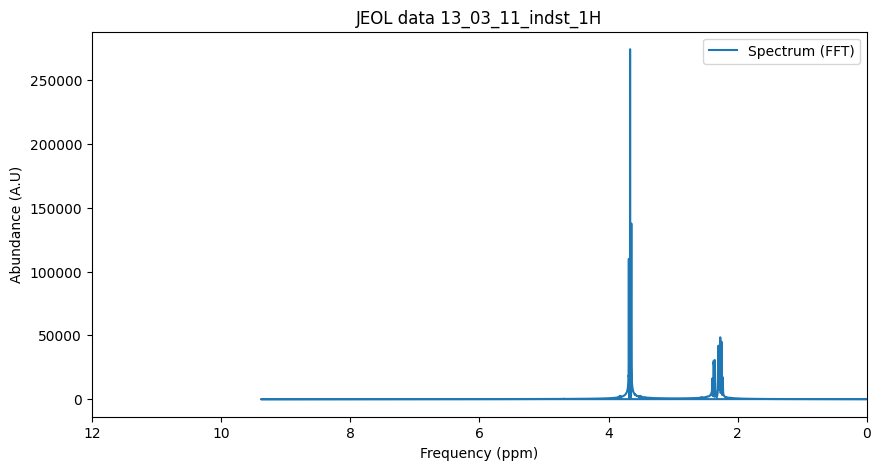

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
plt.gca().invert_xaxis()  # Invert the x-axis
plt.title(name)
plt.xlabel("Frequency (ppm)")
plt.ylabel("Abundance (A.U)")
plt.xlim(12, 0)  # Adjust x-axis limits as needed
plt.legend()
plt.show()

## Creating the threshold for the chemical signals

This part I will be focusing in on identifying an appropiate threshold. It may be done automatically, like "identify the highest peak, the if anything is 85% less intense than that peak then ignore it" type energy.... By nature we will also be zooming in on the spectra

In [8]:
from scipy.signal import find_peaks

This takes in the phased spectrum part, the frequency and the magnitudes and the ppm shifts and then returns the identified group once its called via a defined dictionary and later a molecular proposition

In [ ]:

def identify_functional_groups(positive_frequencies, positive_magnitudes, ppm_shifts):
    """
    Identify functional groups based on peak positions in the spectrum.

    args: 
        positive_frequencies (np.ndarray): Frequencies in ppm.
        positive_magnitudes (np.ndarray): Magnitudes of the FFT result.
        ppm_shifts (dict): Dictionary mapping functional groups to their ppm ranges.
    """
    # Find peaks in the spectrum
    peaks, _ = find_peaks(positive_magnitudes, height=0.1 * max(positive_magnitudes))  # Adjust height threshold as needed
    peak_positions = positive_frequencies[peaks]

    # Map peaks to functional groups
    #place holder for the identified groups
    identified_groups = []
    for peak in peak_positions:
        for group, ppm_range in ppm_shifts.items():
            # Parse the ppm range
            # this takes in the ppm ranges as a float and then makes a list of them (map)
            ppm_min, ppm_max = map(float, ppm_range.replace("ppm", "").split("-"))
            if ppm_min <= peak <= ppm_max:
                identified_groups.append((peak, group))
                break

    return identified_groups

# Define the ppm shifts for functional groups
ppm_shifts = {
    "Carboxylic acid": "10-12 ppm",
    "Aldehyde": "9-10 ppm",
    "Benzene ring": "6.5-8.5 ppm",
    "Hydrogen on an alkene": "4.5-6.5 ppm",
    "Benzylic carbons": "2-2.5 ppm",
    "CH2 on a halogen": "2.5-4.5 ppm",
    "Methyl ketone": "2-2.5 ppm",
    "CH": "0.9-1.1 ppm",
    "CH2": "1.1-1.4 ppm",
    "CH3": "1.4-1.7 ppm"
}

# Identify functional groups based on the spectrum
identified_groups = identify_functional_groups(
    fftshift(positive_frequencies) / 399.78219838,  # Convert frequencies to ppm
    fftshift(positive_magnitude),
    ppm_shifts
)

# Print the identified functional groups
if identified_groups:
    print("Identified functional groups:")
    for peak, group in identified_groups:
        print(f"The Peak at {peak:.2f} ppm corresponds to a {group}")
else:
    print("No functional groups identified.")

Identified functional groups:
The Peak at 2.25 ppm corresponds to a Benzylic carbons
The Peak at 2.27 ppm corresponds to a Benzylic carbons
The Peak at 2.28 ppm corresponds to a Benzylic carbons
The Peak at 2.28 ppm corresponds to a Benzylic carbons
The Peak at 2.30 ppm corresponds to a Benzylic carbons
The Peak at 2.30 ppm corresponds to a Benzylic carbons
The Peak at 2.35 ppm corresponds to a Benzylic carbons
The Peak at 2.37 ppm corresponds to a Benzylic carbons
The Peak at 2.37 ppm corresponds to a Benzylic carbons
The Peak at 3.65 ppm corresponds to a CH2 on a halogen
The Peak at 3.67 ppm corresponds to a CH2 on a halogen
The Peak at 3.69 ppm corresponds to a CH2 on a halogen


Takes in the max and min ppm peaks and adds a buffer then automatically zooms into them and visualizes them

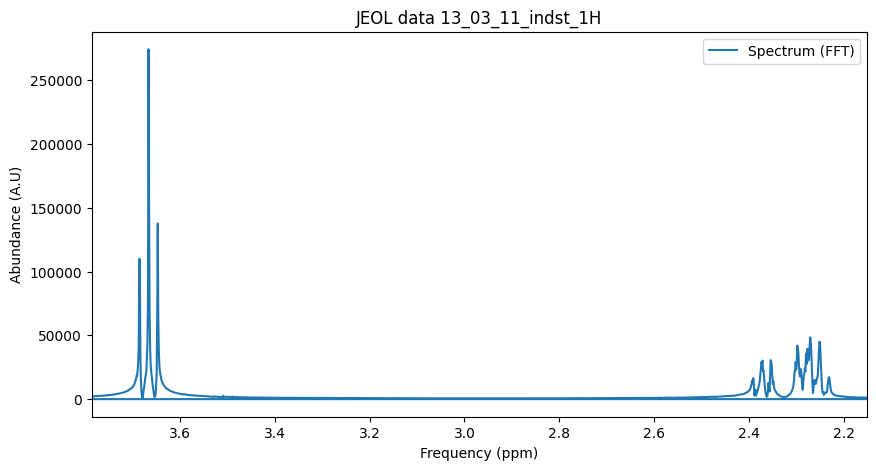

Graph automatically zoomed to range: 2.15 ppm to 3.79 ppm


In [10]:
# Automatically adjust the graph limits based on identified functional groups
if identified_groups:
    # Extract the ppm values of the identified peaks
    peak_ppms = [peak for peak, _ in identified_groups]
    x_min = min(peak_ppms) - 0.1  # Add a small buffer for better visualization
    x_max = max(peak_ppms) + 0.1

    # Plot the spectrum with adjusted x-axis limits
    plt.figure(figsize=(10, 5))
    plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
    plt.gca().invert_xaxis()  # Invert the x-axis
    plt.title(name)
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U)")
    plt.xlim(x_max, x_min)  # Set x-axis limits based on identified peaks
    plt.legend()
    plt.show()

    print(f"Graph automatically zoomed to range: {x_min:.2f} ppm to {x_max:.2f} ppm")
else:
    print("No functional groups identified. Default graph will be displayed.")
    # Default graph
    plt.figure(figsize=(10, 5))
    plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
    plt.gca().invert_xaxis()  # Invert the x-axis
    plt.title(name)
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U)")
    plt.xlim(x_max, x_min)  # Set x-axis limits based on identified peaks
    plt.legend()
    plt.show()

Set your height threshold, min distance, and min prominents parameters for the code to even detect it as a "peak" you're basically meta-defining what a peak is in the context you are using it (just play with it till it looks right)

In [ ]:
# Set a threshold for peak detection based on abundance (A.U.)
# You can adjust 'height_threshold' to filter out noise and insignificant peaks
height_threshold = 0.1 * max(positive_magnitude)  # Example: 20% of max intensity

# Optionally, set minimum distance and prominence between peaks
min_distance = 100  # Adjust as needed (in data points)
min_prominence = 0.05 * max(positive_magnitude)  # Example: 10% of max intensity

# Find peaks using the specified thresholds
peaks, properties = find_peaks(
    positive_magnitude,
    height=height_threshold,
    distance=min_distance,
    prominence=min_prominence
)

# Print the detected peaks and their properties
#print(f"Number of significant peaks found: {len(peaks)}")
###  print(f"Peak at {peak_ppm:.2f} ppm with height {positive_magnitude[idx]:.2f}")

# You can now use these filtered peaks for further analysis or plotting !


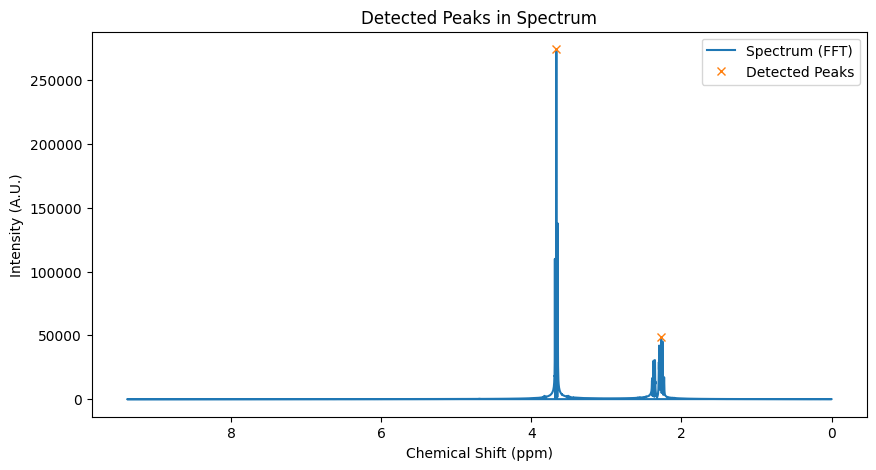

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
plt.plot(fftshift(positive_frequencies[peaks]) / 399.78219838, fftshift(positive_magnitude[peaks]), "x", label="Detected Peaks")
plt.gca().invert_xaxis()  # Invert the x-axis
plt.xlabel("Chemical Shift (ppm)")
plt.ylabel("Intensity (A.U.)")
plt.title("Detected Peaks in Spectrum")
plt.legend()
plt.show()

In [ ]:
# Parameters
ppm_range = 12  # Spectra goes from 0 to 12 ppm
spectrometer_freq = 399.78219838  # MHz
n_points = len(positive_magnitude) #the number of data points in the spectrum

#dont ask too much about this, I just did it.
# Resolution conversions
hz_per_point = (ppm_range * spectrometer_freq) / n_points #looks at ppm range frequwncies and normalizes it for resolution
# Calculate ppm per point
ppm_per_point = ppm_range / n_points

# Choose min distance in Hz (e.g., 7 Hz for typical J-coupling separation, however this varies on what type of spectrum you are looking at)
min_distance_hz = 7
# Convert min distance from Hz to data points
min_distance = int(min_distance_hz / hz_per_point)

# Thresholds
height_threshold = 0.1 * max(positive_magnitude)
min_prominence = 0.05 * max(positive_magnitude)

# Detect peaks
peaks, properties = find_peaks(
    positive_magnitude,
    height=height_threshold,
    distance=min_distance,
    prominence=min_prominence
)

# Convert indices to ppm
peak_ppms = [i * ppm_per_point for i in peaks]
for idx, ppm in zip(peaks, peak_ppms):
    print(f"Peak at {ppm:.2f} ppm with height {positive_magnitude[idx]:.2f}")


Peak at 2.88 ppm with height 45034.89
Peak at 2.90 ppm with height 48471.76
Peak at 2.94 ppm with height 42000.17
Peak at 3.01 ppm with height 30650.04
Peak at 3.03 ppm with height 30232.82
Peak at 4.66 ppm with height 137644.17
Peak at 4.69 ppm with height 274129.02
Peak at 4.71 ppm with height 109922.51


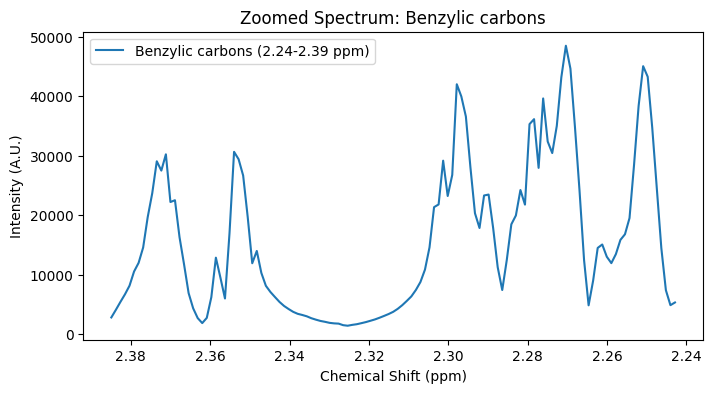

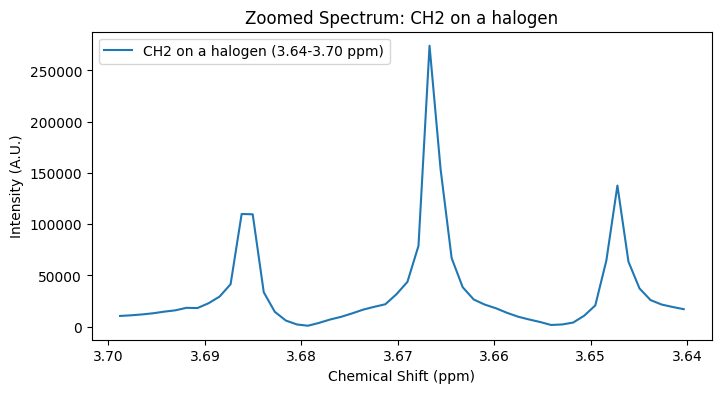

In [ ]:
def auto_zoom_functional_groups(positive_frequencies, positive_magnitude, identified_groups, ppm_shifts, buffer=0.01):
    """
    For each functional group with detected peaks, plot a zoomed-in graph
    covering the range from the lowest to highest detected peak in that group,
    with a buffer added to both sides.
    Args:
        positive_frequencies (np.ndarray): Frequencies in ppm.
        positive_magnitude (np.ndarray): Magnitudes of the FFT result.
        identified_groups (list): List of tuples with peak positions and their corresponding functional groups.
        ppm_shifts (dict): Dictionary mapping functional groups to their ppm ranges.
        buffer (float): Buffer to add around the zoomed region in ppm.
    """
    # Group peaks by functional group
    group_peaks = {}
    for peak_ppm, group in identified_groups:
        group_peaks.setdefault(group, []).append(peak_ppm)

    for group, peaks in group_peaks.items():
        ppm_range_str = ppm_shifts.get(group)
        if not ppm_range_str:
            continue
        ppm_min, ppm_max = map(float, ppm_range_str.replace("ppm", "").split("-"))
        # Only consider peaks within the defined ppm range for the group
        peaks_in_range = [ppm for ppm in peaks if ppm_min <= ppm <= ppm_max]
        if not peaks_in_range:
            continue
        # Define zoom window: min and max peak in group ± buffer
        zoom_min = min(peaks_in_range) - buffer
        zoom_max = max(peaks_in_range) + buffer
        # Mask for the zoomed region
        ppm_axis = positive_frequencies / 399.78219838
        mask = (ppm_axis >= zoom_min) & (ppm_axis <= zoom_max)
        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(ppm_axis[mask], positive_magnitude[mask], label=f"{group} ({zoom_min:.2f}-{zoom_max:.2f} ppm)")
        plt.gca().invert_xaxis()
        plt.title(f"Zoomed Spectrum: {group}")
        plt.xlabel("Chemical Shift (ppm)")
        plt.ylabel("Intensity (A.U.)")
        plt.legend()
        plt.show()

auto_zoom_functional_groups(
    fftshift(positive_frequencies),
    fftshift(positive_magnitude),
    identified_groups,
    ppm_shifts,
    buffer=0.01
)

# Peak Integration

### What is Peak Integration?
- **Peak integration** measures the **area under an NMR signal peak**, which corresponds to the **relative number of nuclei** producing that signal.
- This area is proportional to the **number of equivalent protons** (or other nuclei) in that chemical environment.
- Integration allows us to determine **relative ratios** of different types of protons in a molecule, which is key for structure elucidation.

### Mathematical Definition
- Given a peak represented by a function $f(\delta)$, where $f(\delta)$ is the intensity at chemical shift $\delta$ (in ppm), the **integrated area** $A$ over the peak range $[a, b]$ is:

  $$
  A = \int_{a}^{b} f(\delta) \, d\delta
  $$

- In practice, the spectrum is **digitized** at discrete points $\{ \delta_i, f_i \}$, so the integral is approximated numerically, often using **Simpson's rule** or the **trapezoidal rule**:

  $$
  A \approx \sum_{i=m}^{n} f_i \, \Delta \delta_i
  $$

  where $m$ and $n$ are the indices corresponding to the integration limits $a$ and $b$, and $\Delta \delta_i = \delta_{i+1} - \delta_i$.

### Why Use Numerical Integration?
- NMR data consists of discrete intensity values at sampled chemical shifts, not a continuous function.
- Numerical integration accounts for **peak shapes and widths**, capturing total area more accurately than just peak height.

### Relative Integration and Normalization
- Since the absolute areas depend on instrument sensitivity and sample concentration, we often use **relative integration** by normalizing all peak areas to the smallest peak area:

  $$
  A_{\text{relative}, i} = \frac{A_i}{\min_j A_j}
  $$

- These relative integrals are then **rounded** to assign integer values corresponding to the number of nuclei (e.g., 1, 2, 3 protons).

---

This integration process connects raw NMR intensity data to meaningful chemical information about the number and environment of nuclei, bridging experimental data with molecular structure.

We use the simpsons integration numerical method since it uses parabolic arcs instead of straightlines to integrate and since that nmr is discrete simpsons rule lets us get a more accurate estimation of under the peak that summing it or the trapazoid rule

In [ ]:
from scipy.integrate import simpson as simps


In [ ]:
# Integrate each detected peak using its left and right bases from the 'properties' dictionary

integrated_areas = []
for i, peak_idx in enumerate(peaks):
    left = properties['left_bases'][i]
    right = properties['right_bases'][i]
    # Extract the region for integration
    freq_region = positive_frequencies[left:right+1]
    mag_region = positive_magnitude[left:right+1]
    # Integrate using Simpson's rule
    area = simps(mag_region, freq_region)
    integrated_areas.append(area)

# Print the integrated area for each peak in arbitrary units (A.U.)
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    print(f"Peak at {peak_ppm:.2f} ppm: Integrated area = {integrated_areas[i]:.2f}")

Peak at 2.25 ppm: Integrated area = 455020.82
Peak at 2.27 ppm: Integrated area = 1519835.17
Peak at 2.30 ppm: Integrated area = 812636.39
Peak at 2.35 ppm: Integrated area = 594888.16
Peak at 2.37 ppm: Integrated area = 473637.27
Peak at 3.65 ppm: Integrated area = 2118553.53
Peak at 3.67 ppm: Integrated area = 3268420.34
Peak at 3.69 ppm: Integrated area = 764856.29


In [ ]:
#this is a list of data containing the peak ppm and its integrated area
# Precompute peak data: (ppm, area)
peak_data = []
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    area = integrated_areas[i]
    peak_data.append((peak_ppm, area))


Now that we have the integration the numbers are numerically okay but they aren't to scale of our 1H nmr. Basically we divide each area by the smallest area like that stoichiometry thing.

In [ ]:
# Normalize to smallest peak (assuming it's not noise) we do this by dividing each area by the smallest area
min_area = min(integrated_areas)
normalized_integrals = [area / min_area for area in integrated_areas]

# Optionally round to nearest half or whole number
rounded_integrals = [round(val, 1) for val in normalized_integrals]

# Print with normalized integration values
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    print(f"Peak at {peak_ppm:.2f} ppm: Relative integration = {rounded_integrals[i]}")

Peak at 2.25 ppm: Relative integration = 1.0
Peak at 2.27 ppm: Relative integration = 3.3
Peak at 2.30 ppm: Relative integration = 1.8
Peak at 2.35 ppm: Relative integration = 1.3
Peak at 2.37 ppm: Relative integration = 1.0
Peak at 3.65 ppm: Relative integration = 4.7
Peak at 3.67 ppm: Relative integration = 7.2
Peak at 3.69 ppm: Relative integration = 1.7


Rounds the value to the nearest 0.0001 point. can be made more precise if needed and again more molecular propositions

In [17]:
def smart_round(val, threshold=0.0001):
    lower = int(val)
    upper = lower + 1
    if val - lower < 0.5 - threshold:
        return lower
    elif val - lower > 0.5 + threshold:
        return upper
    else:
        return round(val)  # round normally if within the threshold window

Apply smart round to the integration thing (lwk redundant, I could've optimized this, but ig this is my process)

In [18]:
# Normalize by the smallest non-zero area
min_area = min(integrated_areas)
relative_integrals = [area / min_area for area in integrated_areas]

# Round them if desired (e.g. to 1 decimal place or to nearest integer)
rounded_integrals = [smart_round(val, 0.001) for val in relative_integrals]

# Build peak_data using the normalized values
peak_data = [
    (positive_frequencies[peak_idx] / spectrometer_freq, rounded_integrals[i])
    for i, peak_idx in enumerate(peaks)
]

# Print the relative integration for each peak
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    print(f"Peak at {peak_ppm:.2f} ppm: Relative integration = {rounded_integrals[i]}")

Peak at 2.25 ppm: Relative integration = 1
Peak at 2.27 ppm: Relative integration = 3
Peak at 2.30 ppm: Relative integration = 2
Peak at 2.35 ppm: Relative integration = 1
Peak at 2.37 ppm: Relative integration = 1
Peak at 3.65 ppm: Relative integration = 5
Peak at 3.67 ppm: Relative integration = 7
Peak at 3.69 ppm: Relative integration = 2


Now that we have the integration we can combine the integration and the functional group analysis together

In [ ]:
def auto_zoom_functional_groups_with_integration(positive_frequencies, positive_magnitude, identified_groups, ppm_shifts, peak_data, buffer=0.01):
    """
    For each functional group with detected peaks, plot a zoomed-in graph
    including integrated peak annotations.
    Args:
        positive_frequencies (np.ndarray): Frequencies in ppm.
        positive_magnitude (np.ndarray): Magnitudes of the FFT result.
        identified_groups (list): List of tuples with peak positions and their corresponding functional groups.
        ppm_shifts (dict): Dictionary mapping functional groups to their ppm ranges.
        peak_data (list): List of tuples with peak ppm and its integrated area.
        buffer (float): Buffer to add around the zoomed region in ppm.
    """
    # Group peaks by functional group
    group_peaks = {}
    for peak_ppm, group in identified_groups:
        group_peaks.setdefault(group, []).append(peak_ppm)

    for group, peaks in group_peaks.items():
        ppm_range_str = ppm_shifts.get(group)
        if not ppm_range_str:
            continue
        ppm_min, ppm_max = map(float, ppm_range_str.replace("ppm", "").split("-"))
        # Only consider peaks within the defined ppm range for the group
        peaks_in_range = [ppm for ppm in peaks if ppm_min <= ppm <= ppm_max]
        if not peaks_in_range:
            continue

        # Define zoom window
        zoom_min = min(peaks_in_range) - buffer
        zoom_max = max(peaks_in_range) + buffer

        # Create ppm axis
        ppm_axis = positive_frequencies / 399.78219838
        mask = (ppm_axis >= zoom_min) & (ppm_axis <= zoom_max)

        # Plot spectrum
        plt.figure(figsize=(8, 4))
        plt.plot(ppm_axis[mask], positive_magnitude[mask], label=f"{group} ({zoom_min:.2f}-{zoom_max:.2f} ppm)")

        # Annotate integrated peaks within this region
        for ppm, area in peak_data:
            if zoom_min <= ppm <= zoom_max:
                plt.axvline(ppm, color='black', linestyle='--', linewidth=1)
                # Offset the text slightly to the right of the line
                plt.text(
                    ppm + 0.01,  # shift right by 0.01 ppm
                    max(positive_magnitude[mask]) * 0.9,
                    f"{area:.2f}",
                    rotation=0,  # horizontal text
                    va='center',
                    ha='left',
                    fontsize=9,
                    color='black',
                    fontweight='bold'
                )

        plt.gca().invert_xaxis()
        plt.title(f"Zoomed Spectrum: {group}")
        plt.xlabel("Chemical Shift (ppm)")
        plt.ylabel("Intensity (A.U.)")
        plt.legend()
        plt.tight_layout()
        plt.show()

use the function on spectra

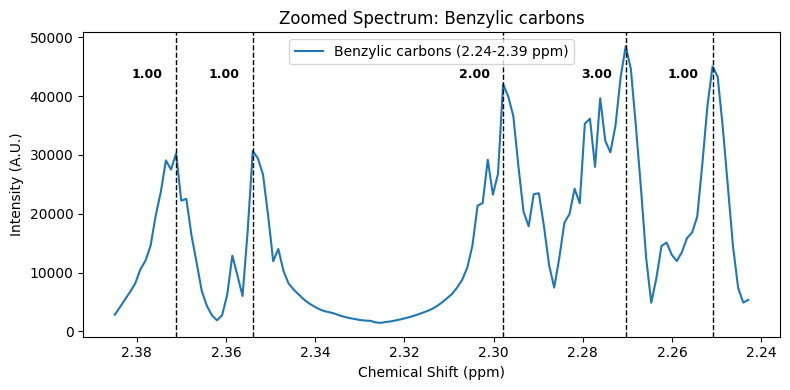

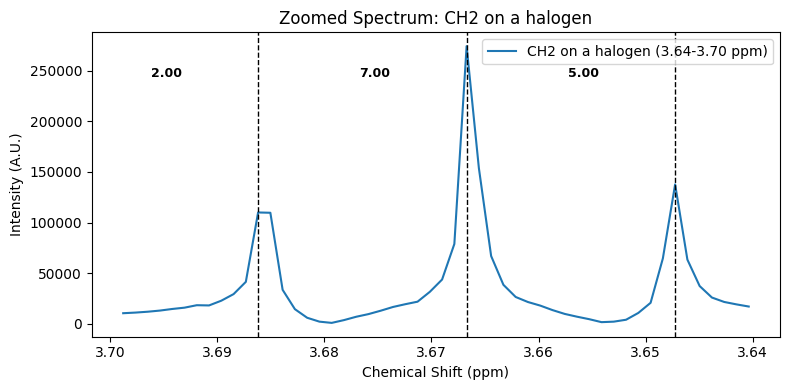

In [20]:
auto_zoom_functional_groups_with_integration(
    fftshift(positive_frequencies),
    fftshift(positive_magnitude),
    identified_groups,
    ppm_shifts,
    peak_data,
    buffer=0.01
)

# Spin-Spin Coupling

### What is Spin-Spin Coupling?
- **Spin-spin coupling** (also called **J-coupling**) is the interaction between magnetic nuclei through chemical bonds.
- This interaction causes a single NMR signal to split into multiple peaks, known as a **multiplet**.
- The pattern and spacing of these multiplets provide information about the number and proximity of neighboring nuclei.

### Multiplet Patterns
- The number of peaks in a multiplet follows the **n+1 rule**:  
  If a proton has *n* equivalent neighboring protons, its signal splits into *n+1* peaks.
- Common patterns:
  - **Singlet**: No neighbors (1 peak)
  - **Doublet**: 1 neighbor (2 peaks)
  - **Triplet**: 2 neighbors (3 peaks)
  - **Quartet**: 3 neighbors (4 peaks)
  - **Multiplet**: Complex splitting from multiple or non-equivalent neighbors

### J-Coupling Constant (J)
- The **J-coupling constant** ($J$) measures the separation between peaks in a multiplet, reported in **Hertz (Hz)**.
- $J$ is independent of the external magnetic field strength and depends on the number of bonds and the geometry between nuclei.
- The distance in ppm can be converted to Hz using:
  $$
  J (\text{Hz}) = \Delta \delta (\text{ppm}) \times \nu_{\text{spectrometer}} (\text{MHz})
  $$

### Why is Spin-Spin Coupling Important?
- Multiplet patterns and J values help determine the number of neighboring protons and their connectivity.
- This information is crucial for deducing molecular structure and identifying functional groups.


In [21]:
# Example: Convert ppm difference to Hz
def ppm_to_hz(ppm_diff, spectrometer_freq):
    return ppm_diff * spectrometer_freq

def detect_multiplet(ppm_axis, intensity, center_ppm, window=0.05):
    mask = (ppm_axis > center_ppm - window) & (ppm_axis < center_ppm + window)
    sub_peaks, _ = find_peaks(intensity[mask], height=0.1 * max(intensity[mask]))
    sub_ppms = ppm_axis[mask][sub_peaks]
    return sub_ppms

def estimate_j_coupling(sub_ppms, spectrometer_freq):
    sub_ppms = sorted(sub_ppms)
    j_values = []
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i-1])
        j_values.append(ppm_to_hz(ppm_diff, spectrometer_freq))
    return j_values

def estimate_j_couplings_from_multiplet(ppm_axis, intensity, center_ppm, spectrometer_freq, window=0.05):
    mask = (ppm_axis > center_ppm - window) & (ppm_axis < center_ppm + window)
    sub_peaks, _ = find_peaks(intensity[mask], height=0.1 * max(intensity[mask]))
    sub_ppms = ppm_axis[mask][sub_peaks]
    
    # Sort and compute J values
    sub_ppms = np.sort(sub_ppms)
    j_couplings = []
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i - 1])
        j_hz = ppm_to_hz(ppm_diff, spectrometer_freq)
        j_couplings.append(j_hz)
    
    return sub_ppms, j_couplings

In [ ]:
def detect_and_plot_multiplet(
    ppm_axis, intensity, center_ppm, spectrometer_freq, window=0.02,
    integration_lookup=None, group_name=None
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks
    from scipy.ndimage import gaussian_filter1d

    # Mask for the region of interest
    mask = (ppm_axis > center_ppm - window) & (ppm_axis < center_ppm + window)
    region_ppm = ppm_axis[mask]
    region_intensity = intensity[mask]

    # Smooth the intensity to reduce noise
    region_intensity = gaussian_filter1d(region_intensity, sigma=2)

    # Find sub-peaks in the region with stricter thresholds
    sub_peaks, _ = find_peaks(
        region_intensity,
        height=0.2 * max(region_intensity),
        prominence=0.1 * max(region_intensity)
    )
    sub_ppms = region_ppm[sub_peaks]

    # Sort sub-peaks and estimate J-couplings
    sub_ppms = np.sort(sub_ppms)
    j_couplings = []
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i-1])
        if ppm_diff < 0.02:  # adjust threshold as needed
            j_hz = ppm_diff * spectrometer_freq
            j_couplings.append(j_hz)

    # Plot the multiplet region
    plt.figure(figsize=(8, 4))
    label = f"{group_name} ({min(region_ppm):.2f}-{max(region_ppm):.2f} ppm)" if group_name else None
    plt.plot(region_ppm, region_intensity, label=label)

    # Annotate sub-peaks with integration values
    for i, ppm in enumerate(sub_ppms):
        plt.axvline(ppm, color='black', linestyle='--', linewidth=1)
        integration_val = None
        if integration_lookup is not None:
            closest = min(integration_lookup, key=lambda x: abs(x[0] - ppm))
            if abs(closest[0] - ppm) < 0.02:
                integration_val = closest[1]
        y_val = region_intensity[sub_peaks[i]] * 0.95
        if integration_val is not None:
            plt.text(
                ppm + 0.01,
                y_val,
                f"{integration_val:.2f}",
                rotation=0,
                va='center',
                ha='left',
                fontsize=8,
                color='black',
                fontweight='bold'
            )

    # Cluster sub-peaks into multiplets
    multiplets = []
    current = [sub_ppms[0]] if len(sub_ppms) > 0 else []
    for i in range(1, len(sub_ppms)):
        if abs(sub_ppms[i] - sub_ppms[i-1]) < 0.05:
            current.append(sub_ppms[i])
        else:
            multiplets.append(current)
            current = [sub_ppms[i]]
    if current:
        multiplets.append(current)

    # Annotate J values within each multiplet
    for group in multiplets:
        for i in range(1, len(group)):
            ppm1, ppm2 = group[i-1], group[i]
            ppm_diff = abs(ppm2 - ppm1)
            mid_ppm = (ppm1 + ppm2) / 2
            y_mid = max(region_intensity) * 0.8
            j_hz = ppm_diff * spectrometer_freq
            plt.text(
                mid_ppm, y_mid,
                f"J = {j_hz:.3f} Hz",
                ha='center', va='bottom', fontsize=7.5, color='red', fontweight='bold'
            )
            plt.plot([ppm1, ppm2], [y_mid*0.98, y_mid*0.98], color='red', linewidth=1)
    # Annotate J-couplings between sub-peaks
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i-1])
        if ppm_diff < 0.05:  # Only annotate if peaks are close enough (same multiplet)
            mid_ppm = (sub_ppms[i] + sub_ppms[i-1]) / 2
            y_mid = max(region_intensity) * 0.8
            j_hz = ppm_diff * spectrometer_freq
            plt.text(
                mid_ppm, y_mid,
                f"J = {j_hz:.3f} Hz",
                ha='center', va='bottom', fontsize=7.5, color='red', fontweight='bold'
            )
            plt.plot([sub_ppms[i-1], sub_ppms[i]], [y_mid*0.98, y_mid*0.98], color='red', linewidth=1)

    plt.gca().invert_xaxis()
    plt.title(f"Zoomed Spectrum: {group_name or f'Multiplet near {center_ppm:.2f} ppm'}")
    plt.xlabel("Chemical Shift (ppm)")
    plt.ylabel("Intensity (A.U.)")
    if label:
        plt.legend()
    plt.tight_layout()
    plt.show()
    return j_couplings

In [ ]:
# Define ppm_axis and intensity for use in multiplet analysis.... again for some reason this is needed, again, this is for school
ppm_axis = fftshift(positive_frequencies) / spectrometer_freq  # chemical shift axis in ppm
intensity = fftshift(positive_magnitude)  # corresponding intensities


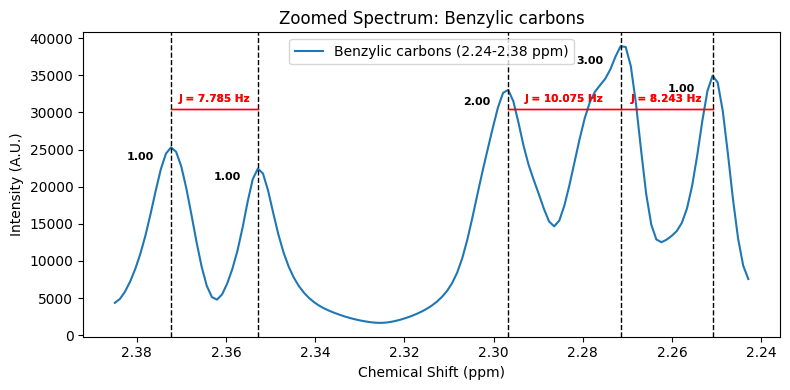

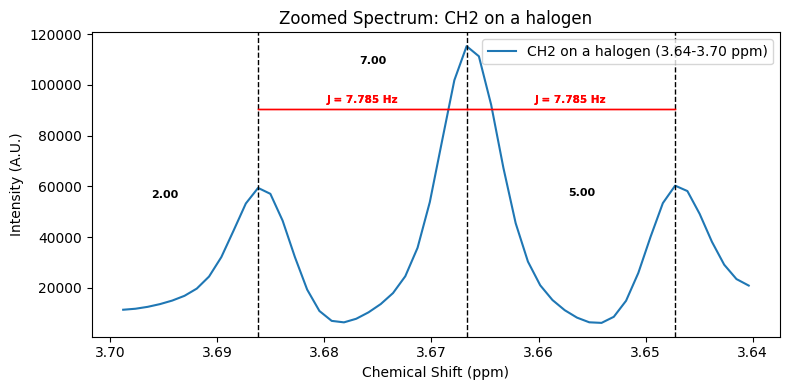

In [51]:
buffer = 0.01  # or match the buffer you use in your zoomed spectrum

for group_name in unique_groups:
    group_peaks = [ppm for ppm, grp in identified_groups if grp == group_name]
    if group_peaks:
        zoom_min = min(group_peaks) - buffer
        zoom_max = max(group_peaks) + buffer
        center_ppm = (zoom_min + zoom_max) / 2
        window = (zoom_max - zoom_min) / 2
        detect_and_plot_multiplet(
            ppm_axis, intensity, center_ppm, spectrometer_freq, window=window,
            integration_lookup=peak_data,
            group_name=group_name
        )

### This is where things get iffy, but also interesting
I need more quantum and mathmatical and coding knowledge, bc I have only been doing it like 10 months and its not like I am learning 100% how to do this in class, but I will probably figure it out shortly after or before the presentation

#### Automate the group name variable
I need to do something so that it can use the zoom into functional group function and then graph it automatically use {group} instead of "CH2 on halogen"

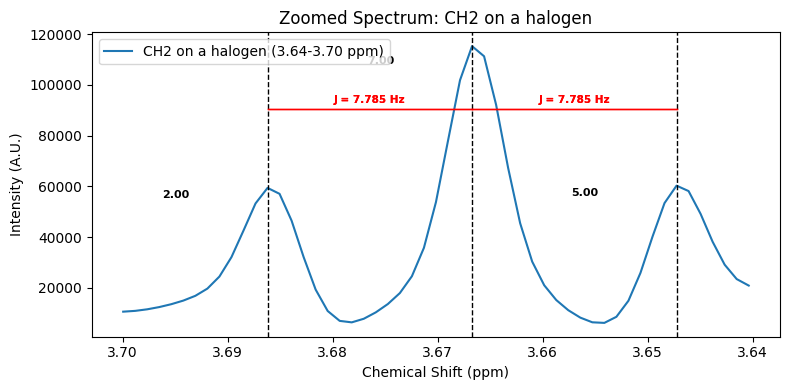

In [52]:
# Example for a specific group (e.g., "CH2 on a halogen")
center_ppm = 3.67  # or whatever center you want
window = 0.03      # adjust as needed

j_couplings = detect_and_plot_multiplet(
    ppm_axis, intensity, center_ppm, spectrometer_freq, window=window,
    integration_lookup=peak_data,
    group_name="CH2 on a halogen"
)
if j_couplings:
    calculated_J = j_couplings[0]  # Use the first J value, or select as needed
else:
    calculated_J = 7  # fallback/default

# Quantum Simulation

**What is it?**  
We use math to predict how a quantum system (like a particle or two hydrogens) behaves and changes over time.

**How does it work?**  
1. **Find the allowed “shapes” and energies:**  
   We solve the Schrödinger equation to get the possible “shapes” (called eigenstates, $\psi_j$) and energies ($E_j$) the system can have:
   $$
   -\frac{1}{2}\frac{\partial^2}{\partial x^2}\psi + V(x)\psi = E\psi
   $$
2. **Build the starting state:**  
   Decide what the system looks like at the start ($\psi(x,0)$).
3. **See how it changes:**  
   Use the formula
   $$
   \psi(x, t) = \sum_j c_j \psi_j(x) e^{-i E_j t}
   $$
   to see how the system evolves over time. The $c_j$ values tell us how much of each “shape” is in our starting state.
4. **Animation:**  
   We can plot and animate how the probability of finding the particle at each position changes as time goes on.

**Why do this?**  
This lets us actually “see” quantum behavior—how a wavefunction moves, bounces, or tunnels through barriers.

**Units and scaling:**  
We use simple units ($\hbar=1$) for the math, but you can convert back to real-world units if you know the mass ($m$) and length ($L$) of your system.

---

*Fast note for yourself:*  
We solve for the allowed quantum states, then use those to see how the system changes over time. The animation shows the wavefunction moving around—this is real quantum behavior in action!

In [ ]:
import numpy as np
from numpy import kron

# Pauli matrices
I = np.eye(2)
sz = np.array([[1, 0], [0, -1]]) / 2

# Zeeman parameters
gamma_H = 42.57747892  # MHz/T
B0 = 399.78219838 / gamma_H  # T
omega0 = -gamma_H * B0 * 2 * np.pi  # rad/s

# Operators for two spins
IzA = kron(sz, I)
IzB = kron(I, sz)

# J-coupling (example: 7 Hz)
calculated_j = 
J_AB = calculated_J  # Hz

# Hamiltonian: Zeeman + J-coupling
omega_A = omega0
omega_B = omega0
H_multi = -omega_A * IzA - omega_B * IzB + 2 * np.pi * J_AB * IzA @ IzB

# Diagonalize
eigvals, eigvecs = np.linalg.eigh(H_multi)
print("Eigenvalues (Hz):", eigvals / (2 * np.pi))
print("Eigenvectors (columns):\n", eigvecs)

# Initial state (example: |00> state)
psi0 = np.zeros(4)
psi0[0] = 1

# Expansion coefficients
c_j = np.dot(eigvecs.conj().T, psi0)

# Time evolution function
def psi_t(t):
    phase = np.exp(-1j * eigvals * t)
    return np.dot(eigvecs, c_j * phase)

# Example: probability of being in |00> at time t
t = 0.01  # seconds (adjust as needed)
psi = psi_t(t)
prob_00 = np.abs(psi[0])**2
print(f"Probability in |00> at t={t}: {prob_00:.3f}")

#ask copilot/chatgpt if this output looks right for what I have, and cross reference them. I was expecting like millions of values, not just 4 eigenvalues
#unless its 4 eigenvalues for the 4 states of the two spins... which would make sense
#look into why 401.53219838 is used as the spectrometer frequency, and if it should be 399.78219838 instead... unless its because of the coupling? 

Eigenvalues (Hz): [-398.03219838   -1.75         -1.75        401.53219838]
Eigenvectors (columns):
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
Probability in |00> at t=0.01: 1.000


<>:90: SyntaxWarning: invalid escape sequence '\p'
<>:93: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\p'
<>:93: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Windows User\AppData\Local\Temp\ipykernel_17368\2095013497.py:90: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
C:\Users\Windows User\AppData\Local\Temp\ipykernel_17368\2095013497.py:93: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')


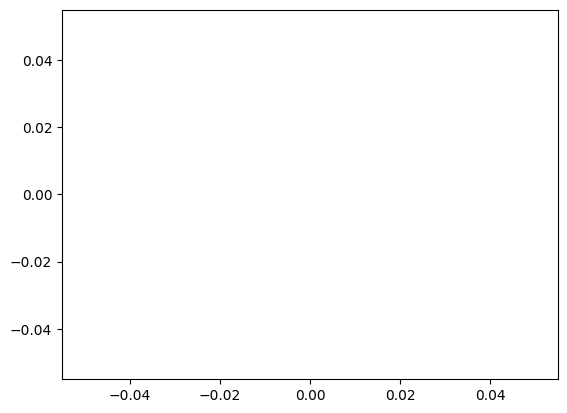

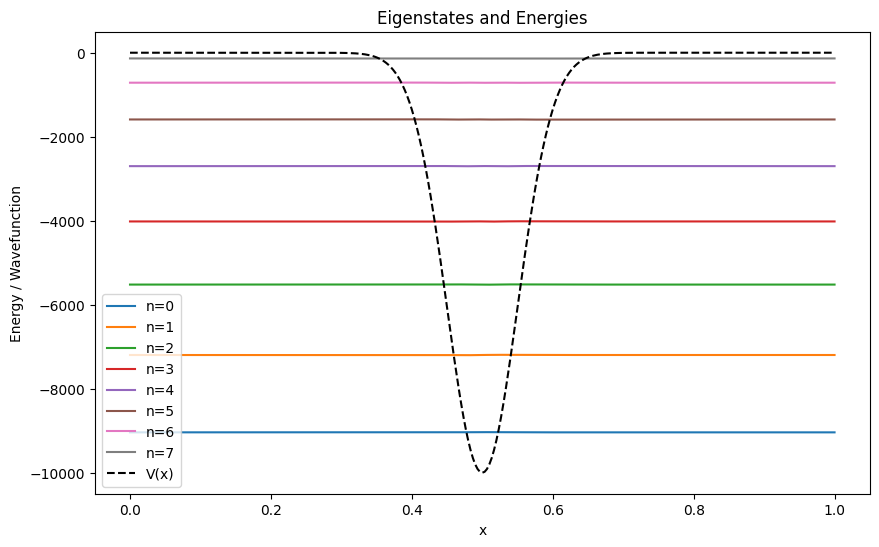

C:\Users\Windows User\AppData\Local\Temp\ipykernel_17368\2095013497.py:90: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
C:\Users\Windows User\AppData\Local\Temp\ipykernel_17368\2095013497.py:93: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')


KeyboardInterrupt: 

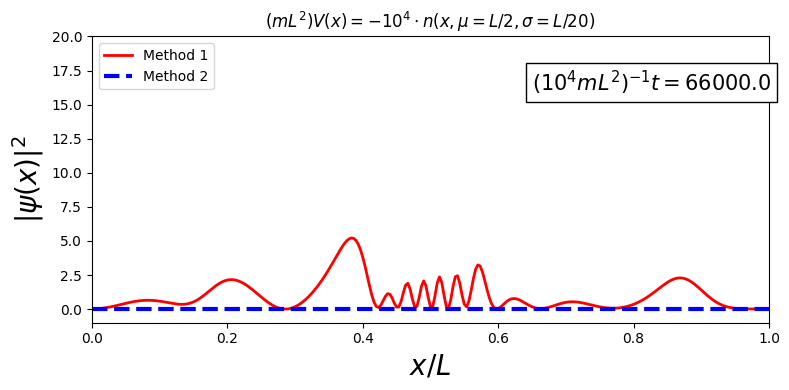

In [48]:
import numpy as np
from scipy.linalg import eigh
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt

# Example: create psi_m1 as a NumPy array
psi_m1 = np.random.rand(1000) + 1j * np.random.rand(1000)  # 1000 complex numbers

import numpy as np
import matplotlib.pyplot as plt

# Define x and psi_m1
x = np.linspace(0, 1, 1000)
psi_m1 = np.random.rand(1000) + 1j * np.random.rand(1000)

fig, ax = plt.subplots()
ln1, = ax.plot([], [], 'r-')

def animate(i):
    idx = min(100*i, len(psi_m1)-1)  # Prevent out-of-bounds
    ln1.set_data(x, np.abs(psi_m1)**2)
    return ln1,

# Now use FuncAnimation as before
# Parameters
N = 301  # number of grid points
L = 1.0  # length of the box (arbitrary units)
x = np.linspace(0, L, N)
dx = x[1] - x[0]
m = 1.0  # mass (arbitrary units)
hbar = 1.0  # use hbar=1 for now

# Gaussian barrier potential
mu = L / 2
sigma = L / 20
V = -1e4 * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Kinetic energy operator (finite difference, tridiagonal)
T = np.zeros((N, N))
for i in range(N):
    T[i, i] = -2
    if i > 0:
        T[i, i-1] = 1
    if i < N-1:
        T[i, i+1] = 1
T = - (hbar**2) / (2 * m * dx**2) * T

# Hamiltonian
H = T + np.diag(V)

# Solve eigenvalue problem
eigvals, eigvecs = eigh(H)
# Normalize eigenvectors
eigvecs = eigvecs / np.sqrt(np.sum(np.abs(eigvecs)**2, axis=0) * dx)

# Plot eigenstates and energies
plt.figure(figsize=(10, 6))
for n in range(8):
    plt.plot(x, eigvecs[:, n] + eigvals[n], label=f'n={n}')
plt.plot(x, V, 'k--', label='V(x)')
plt.xlabel('x')
plt.ylabel('Energy / Wavefunction')
plt.title('Eigenstates and Energies')
plt.legend()
plt.show()

# Initial wavefunction: Gaussian packet
psi0 = np.exp(-((x - L/3) ** 2) / (2 * (L/20) ** 2))
psi0 /= np.sqrt(np.sum(np.abs(psi0) ** 2) * dx)  # normalize

# Expansion coefficients
c_j = np.dot(eigvecs.conj().T, psi0) * dx

# Time evolution function
def psi_xt(t):
    phase = np.exp(-1j * eigvals * t / hbar)
    psi_t = np.dot(eigvecs, c_j * phase)
    return psi_t

# Animate probability density evolution
fig, ax = plt.subplots(1,1, figsize=(8,4))
#ax.grid()
ln1, = ax.plot([], [], 'r-', lw=2, markersize=8, label='Method 1')
ln2, = ax.plot([], [], 'b--', lw=3, markersize=8, label='Method 2')
time_text = ax.text(0.65, 16, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 20)
ax.set_xlim(0,1)
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x/L$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')

# Define dt for time steps
dt = 0.001

# Define psi_m2 as a function for demonstration (returns zeros)
def psi_m2(t):
    # This is a placeholder; replace with your actual psi_m2 calculation
    return np.zeros_like(x)

def animate(i):
    ln1.set_data(x, np.abs(psi_xt(100*i*dt))**2)
    ln2.set_data(x, np.abs(psi_m2(100*i*dt))**2)
    time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(100*i*dt*1e4))
    return ln1, ln2, time_text

plt.tight_layout()
ani = FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif', writer='pillow', fps=50, dpi=100)